# Rule Set 3

> Python package to predict the activity of CRISPR sgRNA sequences using Rule Set 3

## Install

You can install the latest releas of rs3 from pypi using

`pip install rs3`

## Quick Start

### Sequence based model

Import packages

In [ ]:
from rs3.seq import predict_seq

Create a list of context sequences you want to predict

In [ ]:
context_seqs = ['GACGAAAGCGACAACGCGTTCATCCGGGCA', 'AGAAAACACTAGCATCCCCACCCGCGGACT']

You can predict on-target scores for sequences using the `predict_seq` function, specifying either
[Hsu2013](https://www.nature.com/articles/nbt.2647) or
[Chen2013](https://www.sciencedirect.com/science/article/pii/S0092867413015316?via%3Dihub)
as the tracrRNA to score with

In [ ]:
predict_seq(context_seqs, sequence_tracr='Hsu2013')

Calculating sequence-based features


100%|██████████| 2/2 [00:00<00:00, 247.15it/s]


array([-0.86673522,  1.09560723])

### Target and sequence scores

Using the `predict` function we can calculate both target scores and sequence scores. Target-based scores use
information such as amino acid sequence and whether the sgRNA targets in a protein domain.

In [ ]:
import pandas as pd
from rs3.predict import predict
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt

We'll use a list of ~250 sgRNA from the GeckoV2 library as an example dataset

In [ ]:
design_df = pd.read_table('test_data/sgrna-designs.txt')
design_df

,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Transcript,Target Reference Coords,Target Alias,CRISPR Mechanism,Target Domain,...,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Preselected As,Matching Active Arrayed Oligos,Matching Arrayed Constructs,Pools Containing Matching Construct,Pick Order,Picking Round,Picking Notes
0,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,7,GCAGATACAAGAGCAACTGA,NaN,BRDN0004619103,NaN,1,0,Preselected
1,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,48,AAAACTGGCACGACCATCGC,NaN,NaN,NaN,2,0,Preselected
2,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,7,AAAAGATTTGCGCACCCAAG,NaN,NaN,NaN,1,0,Preselected
3,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,8,CTTTGACCCAGACATAATGG,NaN,NaN,NaN,2,0,Preselected
4,TOP1,2,9606,ENSG00000198900,TOP1,ENST00000361337.3,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,1,NaN,NaN,BRDN0001486452,NaN,2,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,RFC5,2,9606,ENSG00000111445,RFC5,ENST00000454402.7,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,23,TTTATATAGCTGTTTCGCAC,NaN,NaN,NaN,1,0,Preselected
396,NXT1,2,9606,ENSG00000132661,NXT1,ENST00000254998.3,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,3,NaN,NaN,BRDN0002419367,NaN,2,1,NaN
397,NXT1,2,9606,ENSG00000132661,NXT1,ENST00000254998.3,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,31,TTTGCTGTCCCGCCTGTACA,NaN,NaN,NaN,1,0,Preselected
398,NOL10,2,9606,ENSG00000115761,NOL10,ENST00000381685.10,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,3,NaN,NaN,NaN,NaN,2,1,NaN


In [ ]:
import multiprocessing
max_n_jobs = multiprocessing.cpu_count()
gecko_activity = pd.read_csv('test_data/Aguirre2016_activity.csv')
gecko_activity

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_mean_centered_neg_lfc
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,CPSF6,22.2,-1.139819
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,SKA3,62.3,-0.793055
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AQR,3.8,0.946453
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,ZNHIT6,61.7,-0.429590
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,ABCF1,9.4,0.734196
...,...,...,...,...,...
8654,TTTGTGGCAGCGAATCATAA,TGTCTTTGTGGCAGCGAATCATAATGGTTC,UMPS,43.8,-0.927345
8655,TTTGTTAATATCTGCTGAAC,TGAATTTGTTAATATCTGCTGAACAGGAGT,GTF2A1,40.3,-0.382060
8656,TTTGTTAGGATGTGCATTCC,TTTCTTTGTTAGGATGTGCATTCCAGGTAC,NAT10,16.4,-0.927645
8657,TTTGTTAGGTCATCGTATTG,GGTTTTTGTTAGGTCATCGTATTGAGGAAG,RPL4,33.5,-1.425502


By listing both tracrRNA `tracr=['Hsu2013', 'Chen2013']` and setting `target=True`, we calculate
5 unique scores: one sequence score for each tracr, the target score, and the sequence scores plus the target score.

In [ ]:
scored_designs = predict(design_df, tracr=['Hsu2013', 'Chen2013'], target=True,
                         n_jobs_min=2, n_jobs_max=max_n_jobs,
                         lite=False,
                         aa_seq_file='test_data/target_data/aa_seqs.pq',
                         conservatin_file='test_data/target_data/conservation.pq',
                         domain_file='test_data/target_data/protein_domains.pq')
scored_designs

Calculating sequence-based features


100%|██████████| 400/400 [00:03<00:00, 112.76it/s]


Calculating sequence-based features


100%|██████████| 400/400 [00:00<00:00, 2364.35it/s]


Getting amino acid sequences


100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Getting protein domains


100%|██████████| 200/200 [00:48<00:00,  4.10it/s]


Getting conservation


100%|██████████| 200/200 [05:01<00:00,  1.51s/it]
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Transcript,Target Reference Coords,Target Alias,CRISPR Mechanism,Target Domain,...,Pick Order,Picking Round,Picking Notes,RS3 Sequence Score (Hsu2013 tracr),RS3 Sequence Score (Chen2013 tracr),Transcript Base,Missing conservation information,Target Score,RS3 Sequence (Hsu2013 tracr) + Target Score,RS3 Sequence (Chen2013 tracr) + Target Score
0,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,1,0,Preselected,0.750904,0.512534,ENST00000259457,False,0.152037,0.902940,0.664571
1,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,2,0,Preselected,-0.218514,-0.095684,ENST00000259457,False,0.064880,-0.153634,-0.030804
2,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,1,0,Preselected,-0.126708,-0.307830,ENST00000394249,False,-0.063012,-0.189720,-0.370842
3,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,2,0,Preselected,0.690050,0.390095,ENST00000394249,False,-0.126357,0.563693,0.263738
4,TOP1,2,9606,ENSG00000198900,TOP1,ENST00000361337.3,NaN,NaN,CRISPRko,CDS,...,2,1,NaN,0.451508,-0.169016,ENST00000361337,False,-0.234410,0.217098,-0.403426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,RFC5,2,9606,ENSG00000111445,RFC5,ENST00000454402.7,NaN,NaN,CRISPRko,CDS,...,1,0,Preselected,-0.220600,-0.022154,ENST00000454402,False,0.101662,-0.118938,0.079508
396,NXT1,2,9606,ENSG00000132661,NXT1,ENST00000254998.3,NaN,NaN,CRISPRko,CDS,...,2,1,NaN,0.621609,0.539656,ENST00000254998,False,0.036224,0.657833,0.575881
397,NXT1,2,9606,ENSG00000132661,NXT1,ENST00000254998.3,NaN,NaN,CRISPRko,CDS,...,1,0,Preselected,0.119830,0.012744,ENST00000254998,False,0.089654,0.209484,0.102398
398,NOL10,2,9606,ENSG00000115761,NOL10,ENST00000381685.10,NaN,NaN,CRISPRko,CDS,...,2,1,NaN,0.798633,0.646323,ENST00000381685,False,0.056575,0.855208,0.702899


In [ ]:
gecko_activity_scores = (gecko_activity.merge(scored_designs,
                                              how='inner',
                                              on=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                  'Target Gene Symbol', 'Target Cut %']))
gecko_activity_scores

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_mean_centered_neg_lfc,Input,Quota,Target Taxon,Target Gene ID,Target Transcript,...,Pick Order,Picking Round,Picking Notes,RS3 Sequence Score (Hsu2013 tracr),RS3 Sequence Score (Chen2013 tracr),Transcript Base,Missing conservation information,Target Score,RS3 Sequence (Hsu2013 tracr) + Target Score,RS3 Sequence (Chen2013 tracr) + Target Score
0,AAAACTGGCACGACCATCGC,CCGGAAAACTGGCACGACCATCGCTGGGGT,PSMB7,16.4,-1.052943,PSMB7,2,9606,ENSG00000136930,ENST00000259457.8,...,2,0,Preselected,-0.218514,-0.095684,ENST00000259457,False,0.064880,-0.153634,-0.030804
1,AAAAGATTTGCGCACCCAAG,TAGAAAAAGATTTGCGCACCCAAGTGGAAT,PRC1,17.0,0.028674,PRC1,2,9606,ENSG00000198901,ENST00000394249.8,...,1,0,Preselected,-0.126708,-0.307830,ENST00000394249,False,-0.063012,-0.189720,-0.370842
2,AAAAGTCCAAGCATAGCAAC,CGGGAAAAGTCCAAGCATAGCAACAGGTAA,TOP1,6.5,0.195309,TOP1,2,9606,ENSG00000198900,ENST00000361337.3,...,1,0,Preselected,-0.356580,-0.082514,ENST00000361337,False,-0.354708,-0.711288,-0.437222
3,AAAGAAGCCTCAACTTCGTC,AGCGAAAGAAGCCTCAACTTCGTCTGGAGA,CENPW,37.5,-1.338209,CENPW,2,9606,ENSG00000203760,ENST00000368328.5,...,2,0,Preselected,-0.663540,-0.303324,ENST00000368328,False,0.129285,-0.534255,-0.174039
4,AAAGTGTGCTTTGTTGGAGA,TACTAAAGTGTGCTTTGTTGGAGATGGCTT,NSA2,60.0,-0.175219,NSA2,2,9606,ENSG00000164346,ENST00000610426.5,...,2,0,Preselected,-0.413636,-0.585179,ENST00000610426,False,-0.113577,-0.527213,-0.698756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,TTTAGCCGGATGCGCAGTGA,CTCTTTTAGCCGGATGCGCAGTGATGGTTT,NKAPD1,20.6,0.627322,NKAPD1,2,9606,ENSG00000150776,ENST00000393047.8,...,1,0,Preselected,0.298329,0.274344,ENST00000393047,False,-0.082951,0.215378,0.191393
248,TTTATATAGCTGTTTCGCAC,TGTCTTTATATAGCTGTTTCGCACAGGCTA,RFC5,21.5,-0.957190,RFC5,2,9606,ENSG00000111445,ENST00000454402.7,...,1,0,Preselected,-0.220600,-0.022154,ENST00000454402,False,0.101662,-0.118938,0.079508
249,TTTGCTGTCCCGCCTGTACA,GGCGTTTGCTGTCCCGCCTGTACATGGGCA,NXT1,27.2,0.176827,NXT1,2,9606,ENSG00000132661,ENST00000254998.3,...,1,0,Preselected,0.119830,0.012744,ENST00000254998,False,0.089654,0.209484,0.102398
250,TTTGTCTGATGACTACTCAA,AAATTTTGTCTGATGACTACTCAAAGGTAT,NOL10,15.6,-0.043965,NOL10,2,9606,ENSG00000115761,ENST00000381685.10,...,1,0,Preselected,0.283254,0.264148,ENST00000381685,False,0.136640,0.419894,0.400789


Since Gecko was screened with the tracrRNA from Hsu et al. 2013, we'll use this as our predictor

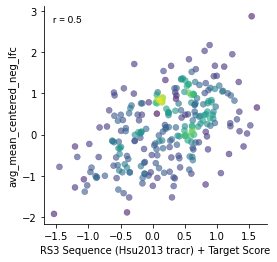

In [ ]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(gecko_activity_scores, y='avg_mean_centered_neg_lfc',
                         x='RS3 Sequence (Hsu2013 tracr) + Target Score')
gpplot.add_correlation(gecko_activity_scores, y='avg_mean_centered_neg_lfc',
                       x='RS3 Sequence (Hsu2013 tracr) + Target Score')
sns.despine()